In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Set directory paths
base_dir = "/Users/macbookpro/Documents/TA/Coding/Data"
if os.path.exists(base_dir):    
    train_dir = os.path.join(base_dir, 'training')
    validation_dir = os.path.join(base_dir, 'validation')
    test_dir = os.path.join(base_dir, 'testing')
else:
    print(f"The folder {base_dir} doesn't exist")

batch_size = 20

# Data Generators
Train_Datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input)
Val_Datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input)
Test_Datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input)

train_gen = Train_Datagen.flow_from_directory(directory=train_dir, target_size=(224, 224), 
                                              batch_size=batch_size, class_mode='categorical', shuffle=True)
val_gen = Val_Datagen.flow_from_directory(directory=validation_dir, target_size=(224, 224), 
                                          batch_size=batch_size, class_mode='categorical', shuffle=False)
test_gen = Test_Datagen.flow_from_directory(directory=test_dir, target_size=(224, 224), 
                                            batch_size=batch_size, class_mode='categorical', shuffle=False)

# The Convolutional Base of the Pre-Trained Model will be added as a Layer in this Model
Conv_Base = EfficientNetV2B2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in Conv_Base.layers[:-8]:
    layer.trainable = False

model = Sequential()
model.add(Conv_Base)
model.add(Flatten())
model.add(Dense(units=224, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=4, activation='softmax'))

# Testing model with a batch of data
x_batch, y_batch = next(train_gen)
model(x_batch)  # Memproses satu batch data
model.summary()  # Output shape akan muncul setelah ini


2024-09-08 22:05:04.435778: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 6541 images belonging to 4 classes.
Found 817 images belonging to 4 classes.
Found 821 images belonging to 4 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b2 (Functional)  │ (20, 7, 7, 1408)       │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (20, 68992)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (20, 224)              │    15,454,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (20, 224)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (20, 4)                │           900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,224,706 (92.41 MB)

 Trainable params: 16,011,012 (61.08 MB)

 Non-trainable params: 8,213,694 (31.33 MB)

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import time

# Hitung waktu sebelum pelatihan dimulai
start_time = time.time()

Number_Of_Training_Images = train_gen.classes.shape[0]
steps_per_epoch = int(Number_Of_Training_Images / batch_size)

# Kompilasi model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definisikan Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Pelatihan model dengan Early Stopping
history = model.fit(train_gen, 
                    epochs=30,  # Epoch maksimal
                    validation_data=val_gen, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[early_stopping])  # Tambahkan Early Stopping pada callback

# Hitung waktu setelah pelatihan selesai
end_time = time.time()

# Hitung total waktu pelatihan
total_time = end_time - start_time
hours = total_time // 3600
minutes = (total_time % 3600) // 60
seconds = total_time % 60

# Cetak waktu pelatihan
print(f"Training time: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")


Epoch 1/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - accuracy: 0.8966 - loss: 0.4193 - val_accuracy: 0.9364 - val_loss: 0.2301
Epoch 2/30
  1/327 ━━━━━━━━━━━━━━━━━━━━ 7:03 1s/step - accuracy: 0.9000 - loss: 0.3210

2024-09-08 22:56:50.555594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


327/327 ━━━━━━━━━━━━━━━━━━━━ 45s 135ms/step - accuracy: 0.9000 - loss: 0.3210 - val_accuracy: 0.9376 - val_loss: 0.2385
Epoch 3/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - accuracy: 0.9094 - loss: 0.3235 - val_accuracy: 0.9547 - val_loss: 0.1317
Epoch 4/30
  1/327 ━━━━━━━━━━━━━━━━━━━━ 6:54 1s/step - accuracy: 0.9000 - loss: 0.2179

2024-09-08 23:05:21.447270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


327/327 ━━━━━━━━━━━━━━━━━━━━ 45s 135ms/step - accuracy: 0.9000 - loss: 0.2179 - val_accuracy: 0.9559 - val_loss: 0.1310
Epoch 5/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 462s 1s/step - accuracy: 0.9327 - loss: 0.2049 - val_accuracy: 0.9572 - val_loss: 0.1487
Epoch 6/30
  1/327 ━━━━━━━━━━━━━━━━━━━━ 6:43 1s/step - accuracy: 0.9500 - loss: 0.1049

2024-09-08 23:13:48.398063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


327/327 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.9500 - loss: 0.1049 - val_accuracy: 0.9535 - val_loss: 0.1501
Epoch 7/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.9292 - loss: 0.2504 - val_accuracy: 0.9523 - val_loss: 0.1658
Epoch 8/30
  1/327 ━━━━━━━━━━━━━━━━━━━━ 8:37 2s/step - accuracy: 0.9000 - loss: 0.1118

2024-09-08 23:24:01.191170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


327/327 ━━━━━━━━━━━━━━━━━━━━ 57s 171ms/step - accuracy: 0.9000 - loss: 0.1118 - val_accuracy: 0.9523 - val_loss: 0.1651
Epoch 9/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.9417 - loss: 0.1705 - val_accuracy: 0.9657 - val_loss: 0.1297
Epoch 10/30
  1/327 ━━━━━━━━━━━━━━━━━━━━ 7:49 1s/step - accuracy: 1.0000 - loss: 0.0660

2024-09-08 23:33:20.842214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


327/327 ━━━━━━━━━━━━━━━━━━━━ 43s 127ms/step - accuracy: 1.0000 - loss: 0.0660 - val_accuracy: 0.9645 - val_loss: 0.1315
Epoch 11/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - accuracy: 0.9593 - loss: 0.1367 - val_accuracy: 0.9572 - val_loss: 0.1392
Epoch 12/30
  1/327 ━━━━━━━━━━━━━━━━━━━━ 7:38 1s/step - accuracy: 1.0000 - loss: 4.5281e-04

2024-09-08 23:45:04.691263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


327/327 ━━━━━━━━━━━━━━━━━━━━ 50s 148ms/step - accuracy: 1.0000 - loss: 4.5281e-04 - val_accuracy: 0.9572 - val_loss: 0.1347
Epoch 13/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 471s 1s/step - accuracy: 0.9624 - loss: 0.1154 - val_accuracy: 0.9645 - val_loss: 0.1053
Epoch 14/30
  1/327 ━━━━━━━━━━━━━━━━━━━━ 6:58 1s/step - accuracy: 1.0000 - loss: 0.0144

2024-09-08 23:53:45.555846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


327/327 ━━━━━━━━━━━━━━━━━━━━ 43s 127ms/step - accuracy: 1.0000 - loss: 0.0144 - val_accuracy: 0.9657 - val_loss: 0.1051
Epoch 15/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1864s 6s/step - accuracy: 0.9534 - loss: 0.1691 - val_accuracy: 0.9657 - val_loss: 0.1973
Epoch 16/30
  1/327 ━━━━━━━━━━━━━━━━━━━━ 6:58 1s/step - accuracy: 0.9500 - loss: 0.1751

2024-09-09 00:25:31.739039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


327/327 ━━━━━━━━━━━━━━━━━━━━ 43s 129ms/step - accuracy: 0.9500 - loss: 0.1751 - val_accuracy: 0.9657 - val_loss: 0.2111
Epoch 17/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 465s 1s/step - accuracy: 0.9553 - loss: 0.1583 - val_accuracy: 0.9670 - val_loss: 0.1797
Epoch 18/30
  1/327 ━━━━━━━━━━━━━━━━━━━━ 6:53 1s/step - accuracy: 0.8500 - loss: 0.6117

2024-09-09 00:33:59.770675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


327/327 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - accuracy: 0.8500 - loss: 0.6117 - val_accuracy: 0.9670 - val_loss: 0.1712
Epoch 19/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1154s 4s/step - accuracy: 0.9650 - loss: 0.1421 - val_accuracy: 0.9572 - val_loss: 0.1984
Training time: 2 hours, 6 minutes, 51.21 seconds


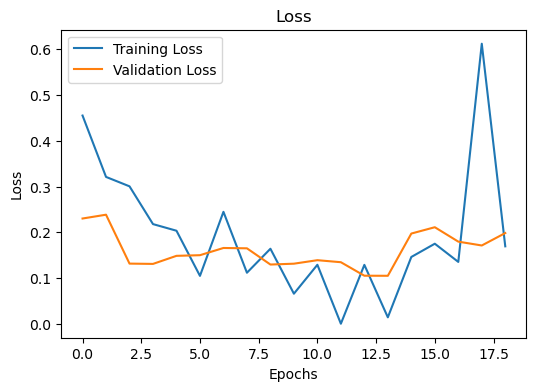

In [6]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Tampilkan grafik loss
plt.show()


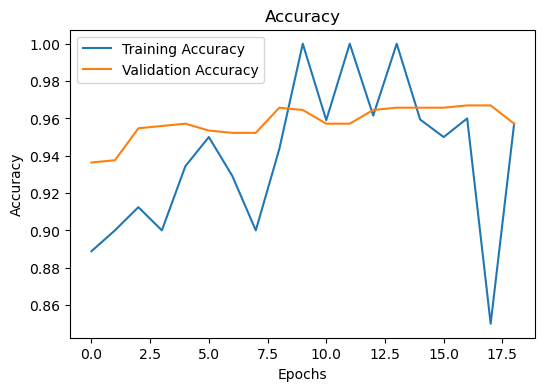

In [7]:
import matplotlib.pyplot as plt

# Plot Akurasi
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Tampilkan grafik akurasi
plt.show()


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
def conclusion_edited_indonesia(model,test_gen, title='Confusion matrix', cmap=plt.cm.Blues):
    test_score = model.evaluate(test_gen)
    print("[INFO] Testing accuracy: {:.2f}%".format(test_score[1] * 100))
    print("[INFO] Testing Loss: ",test_score[0])

    def make_confusion_matrix(y_true, model, test_data, classes=None, figsize=(7, 7), text_size=9): 
        """Makes a labelled confusion matrix comparing predictions and ground truth labels.

        If classes is passed, confusion matrix will be labelled, if not, integer class values
        will be used.

        Args:
            y_true: Array of truth labels (must be same shape as y_pred).
            y_pred: Array of predicted labels (must be same shape as y_true).
            classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
            figsize: Size of output figure (default=(10, 10)).
            text_size: Size of output figure text (default=15).
        
        Returns:
            A labelled confusion matrix plot comparing y_true and y_pred.

        Example usage:
            make_confusion_matrix(y_true=test_labels, # ground truth test labels
                                y_pred=y_preds, # predicted labels
                                classes=class_names, # array of class label names
                                figsize=(15, 15),
                                text_size=10)
        """  
        # Create the confustion matrix
        y_probs = model.predict(test_data)
        y_preds = y_probs.argmax(axis=1)
        cm = confusion_matrix(y_true, y_preds)
        cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
        n_classes = cm.shape[0] # find the number of classes we're dealing with

        # Plot the figure and make it pretty
        fig, ax = plt.subplots(figsize=figsize)
        cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
        fig.colorbar(cax)

        # Are there a list of classes?
        if classes:
            labels = classes
        else:
            labels = np.arange(cm.shape[0])
        
        # Label the axes
        ax.set(title="Confusion Matrix",
                xlabel="Predicted label",
                ylabel="True label",
                xticks=np.arange(n_classes), # create enough axis slots for each class
                yticks=np.arange(n_classes), 
                xticklabels=labels, # axes will labeled with class names (if they exist) or ints
                yticklabels=labels)



        # Make x-axis labels appear on bottom
        ax.xaxis.set_label_position("bottom")
        ax.xaxis.tick_bottom()

        # Set the threshold for different colors
        threshold = (cm.max() + cm.min()) / 2.

        # Plot the text on each cell
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)
         
    #shuffle=False
    target_names = [ 'glioma', 'meningioma', 'pituitary', 'normal']
    # print(target_names)
    #Confution Matrix
    Y_pred = model.predict(test_gen)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    make_confusion_matrix(test_gen.classes, model, test_gen, classes=target_names, figsize=(7, 7), text_size=9)
    #Print Classification Report
    print('Classification Report')
    print(classification_report(test_gen.classes, y_pred, target_names=target_names))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9613 - loss: 0.1162
[INFO] Testing accuracy: 96.35%
[INFO] Testing Loss:  0.13289634883403778
42/42 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step
Confusion Matrix
42/42 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step
Classification Report
              precision    recall  f1-score   support

      glioma       0.94      0.97      0.96       221
  meningioma       0.95      0.92      0.94       209
   pituitary       0.99      0.99      0.99       200
      normal       0.97      0.97      0.97       191

    accuracy                           0.96       821
   macro avg       0.96      0.96      0.96       821
weighted avg       0.96      0.96      0.96       821



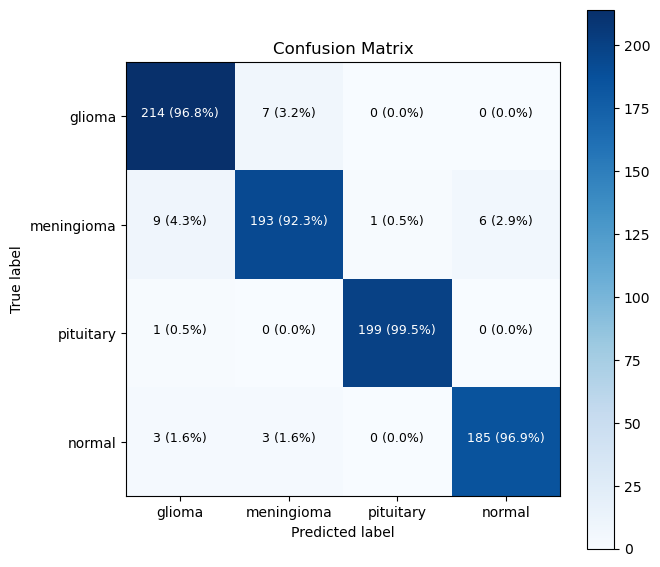

In [9]:
conclusion_edited_indonesia(model,test_gen)

In [17]:
model.save('/Users/macbookpro/Documents/TA/Coding/Model4.keras')

In [18]:
Test = "Ini buat Load model yang udh di save, abis definisiiin reconstruct bisa langsung ditest pake conclusion atau test generator"
import keras
reconstructed_model = keras.models.load_model("/Users/macbookpro/Documents/TA/Coding/Model4.keras")

In [ ]:
Test = "Ini buat Load model yang udh di save, abis definisiiin reconstruct bisa langsung ditest pake conclusion atau test generator"
import keras
reconstructed_model = keras.models.load_model("/Users/macbookpro/Documents/TA/Coding/Model2.keras")

42/42 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9613 - loss: 0.1162
[INFO] Testing accuracy: 96.35%
[INFO] Testing Loss:  0.13289634883403778
42/42 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step
Confusion Matrix
42/42 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step
Classification Report
              precision    recall  f1-score   support

      glioma       0.94      0.97      0.96       221
  meningioma       0.95      0.92      0.94       209
   pituitary       0.99      0.99      0.99       200
      normal       0.97      0.97      0.97       191

    accuracy                           0.96       821
   macro avg       0.96      0.96      0.96       821
weighted avg       0.96      0.96      0.96       821



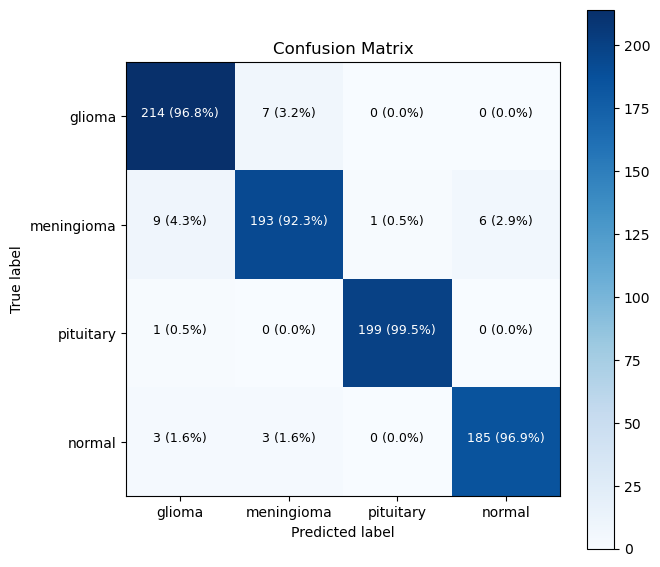

In [19]:
# Kompilasi model (jika belum dikompilasi)
reconstructed_model.compile(optimizer='adam', 
                            loss='categorical_crossentropy', 
                            metrics=['accuracy'])

# Panggil fungsi conclusion_edited_indonesia
conclusion_edited_indonesia(reconstructed_model, test_gen)

42/42 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9613 - loss: 0.1162
[INFO] Testing accuracy: 96.35%
[INFO] Testing Loss:  0.13289634883403778
42/42 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step
Confusion Matrix
42/42 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step
Classification Report
              precision    recall  f1-score   support

      glioma       0.94      0.97      0.96       221
  meningioma       0.95      0.92      0.94       209
   pituitary       0.99      0.99      0.99       200
      normal       0.97      0.97      0.97       191

    accuracy                           0.96       821
   macro avg       0.96      0.96      0.96       821
weighted avg       0.96      0.96      0.96       821



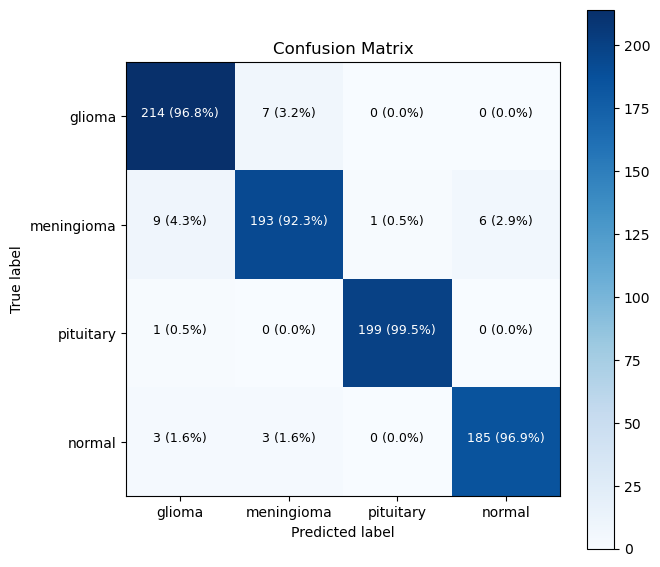

In [20]:
conclusion_edited_indonesia(reconstructed_model,test_gen)

In [24]:
def pr_curve(testing_generator, model):
    predictions_class=model.predict(testing_generator)
    list_class = [ 'glioma', 'meningioma', 'pituitary', 'normal']
    n_classes = len(list_class)
    actual_class = label_binarize(testing_generator.labels, classes=[i for i in range(n_classes)])


    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(actual_class[:, i], predictions_class[:, i])
        average_precision[i] = average_precision_score(actual_class[i], predictions_class[i])
    
    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        actual_class.ravel(), predictions_class.ravel()
    )
    average_precision["micro"] = average_precision_score(actual_class, predictions_class, average="micro")

    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

    _, ax = plt.subplots(figsize=(7, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.8, y[45] + 0.02), fontsize=15)

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {list_class[i]}", color=color)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("PR Curve")

    plt.show()   

In [25]:
def roc_auc_curve(testing_generator, model):
    predictions_class=model.predict(testing_generator)
    list_class = [ 'glioma', 'meningioma', 'pituitary', 'normal']
    n_classes = len(list_class)
    actual_class = label_binarize(testing_generator.labels, classes=[i for i in range(n_classes)])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(actual_class[:, i], predictions_class[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(actual_class.ravel(), predictions_class.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw = 2
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {}:{} (area = {:0.2f})".format(i,list_class[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("False Positive Rate", fontsize = 15)
    plt.ylabel("True Positive Rate", fontsize = 15)
    plt.title("ROC Curve", fontsize = 20)
    plt.legend(loc="lower right", fontsize="12")
    plt.show()

42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step


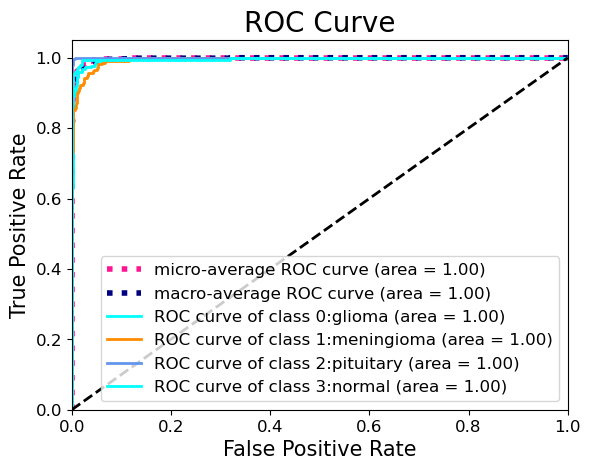

42/42 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step


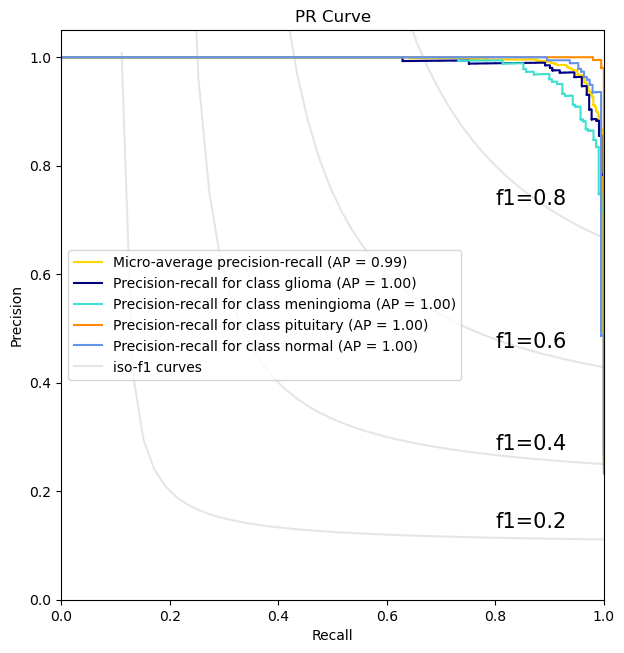

In [26]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
from itertools import cycle

roc_auc_curve(test_gen, reconstructed_model)
pr_curve(test_gen, reconstructed_model)